# Book Recommender System: Unsupervised Learning Project  
**Author:** _Tom Cohen_

## 1. Project Overview and Problem Statement  
Recommender systems typically use **supervised** (ratings prediction) or **implicit‑feedback** objectives.
In this project, we'll pose a *purely unsupervised* question:

> **Can we discover coherent clusters of books and readers with similar preferences, using only historical explicit ratings?**

Such clusters:

* enable **cold‑start tagging** of new items by similarity
* provide **explainable groupings** for librarians or retailers
* can seed downstream semi‑supervised tasks.

We compare two unsupervised pipelines: (SVD, NMF) → clustering via *K‑means*.  
Quality is assessed with several metrics (silhouette, Calinski‑Harabasz) and qualitative inspection.

## 2. Data Exploration and Cleaning

Our dataset is provided by Kaggle: [Book Recommender System](https://www.kaggle.com/datasets/rxsraghavagrawal/book-recommender-system) by RAGHAV AGRAWA
* **The dataset is comprised of three files:**
  * `Books.csv` – contains book metadata (ISBN, Title, Author, Year, Publisher, Image‑URLs).  
  * `Users.csv` – contains user demographics (User‑ID, Location, Age).  
  * `Ratings.csv` – contains 1‑10 explicit ratings (1.1M records).  

| CSV | Rows | Cols |
|-----|------|------|
| Books | 271 360 | 8 |
| Users | 278 858 | 3 |
| Ratings | 1 149 780 | 3 |

In [1]:
!pip install kneed

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.options.display.max_colwidth = 80
DATA_DIR = Path('/kaggle/input/book-recommender-system')

In [3]:
books   = pd.read_csv(DATA_DIR/'BX-Books.csv', low_memory=False, on_bad_lines='skip', sep=';',encoding='latin-1')
users   = pd.read_csv(DATA_DIR/'BX-Users.csv', low_memory=False, on_bad_lines='skip', sep=';',encoding='latin-1')
ratings = pd.read_csv(DATA_DIR/'BX-Book-Ratings.csv', low_memory=False, on_bad_lines='skip', sep=';',encoding='latin-1')
print('Loaded shapes:', books.shape, users.shape, ratings.shape)


Loaded shapes: (271360, 8) (278858, 3) (1149780, 3)


### 2.1  Basic exploration
We'll start by getting a sense of the shape and quality of the data, to inform any future cleaning or wrangling that might be needed.

In [4]:
print("Books Dataset Shape:", books.shape)
print("Users Dataset Shape:", users.shape)
print("Ratings Dataset Shape:", ratings.shape)

print("\nBooks Info:")
books.info()

print("\nUsers Info:")
users.info()

print("\nRatings Info:")
ratings.info()

Books Dataset Shape: (271360, 8)
Users Dataset Shape: (278858, 3)
Ratings Dataset Shape: (1149780, 3)

Books Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB

Users Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null 

Let's see if any datapoint are missing or need other treatment

In [5]:
def plot_missing(missing_data):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=missing_data.index, y=missing_data.values)
    plt.title('Percentage of Missing Values by Feature')
    plt.ylabel('Percentage Missing (%)')
    plt.xticks(rotation=45)
    plt.show()

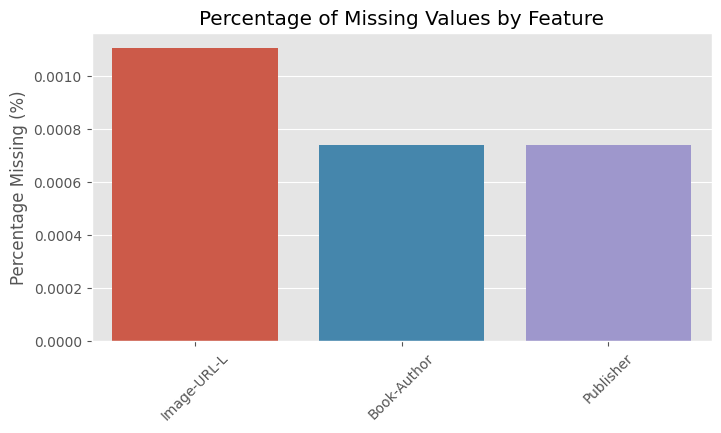

In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = books.isnull().sum() / len(books) * 100
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

plot_missing(missing_data)

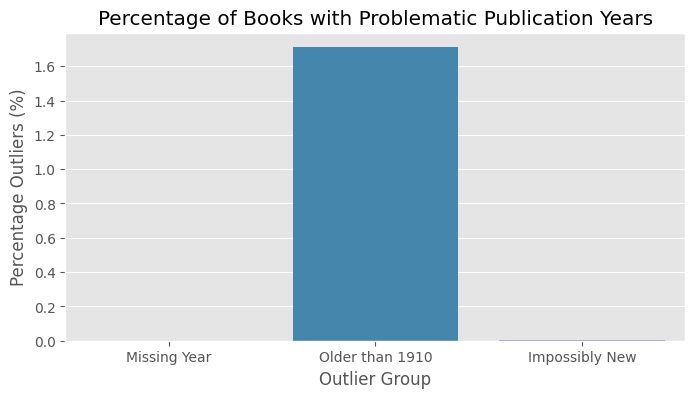

In [7]:
# Check for outliers
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
book_year_nan = (books['Year-Of-Publication'].isna()).sum() / len(books) * 100
extremely_old = len(books[(books['Year-Of-Publication'] < 1910)]) / len(books) * 100
too_new = len(books[(books['Year-Of-Publication'] > 2024)]) / len(books) * 100
outlier_data = {
    'Outlier Category': ['Missing Year', 'Older than 1910', 'Impossibly New'],
    'Percentage': [book_year_nan, extremely_old,too_new]
}
outlier_df = pd.DataFrame(outlier_data)
plt.figure(figsize=(8, 4))
sns.barplot(x='Outlier Category', y='Percentage', data=outlier_df)
plt.title('Percentage of Books with Problematic Publication Years')
plt.ylabel('Percentage Outliers (%)')
plt.xlabel('Outlier Group')
plt.show()

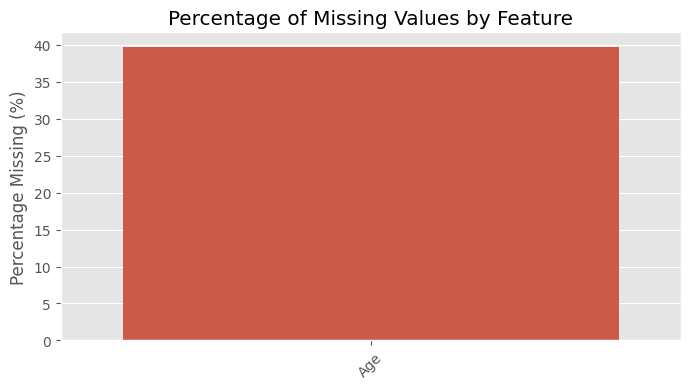

In [8]:
# Calculate the percentage of missing values for each column
missing_percentage = users.isnull().sum() / len(users) * 100
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

plot_missing(missing_data)

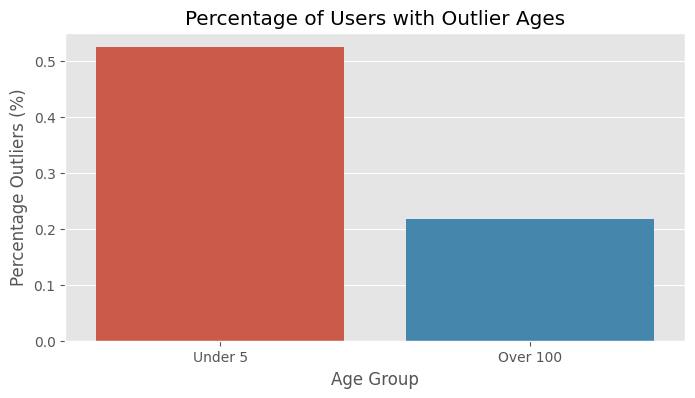

In [9]:
# Check for age outliers
no_na_users = users.dropna() # Temporarily drop nas to see what's happening in the rest of the data
under_five = len(no_na_users[(no_na_users['Age'] < 5)]) / len(no_na_users) * 100
over_hundred = len(no_na_users[(no_na_users['Age'] > 100)]) / len(no_na_users) * 100
outlier_data = {
    'Outlier Category': ['Under 5', 'Over 100'],
    'Percentage': [under_five, over_hundred]
}
outlier_df = pd.DataFrame(outlier_data)
plt.figure(figsize=(8, 4))
sns.barplot(x='Outlier Category', y='Percentage', data=outlier_df)
plt.title('Percentage of Users with Outlier Ages')
plt.ylabel('Percentage Outliers (%)')
plt.xlabel('Age Group') # Added an x-axis label for clarity
plt.show()

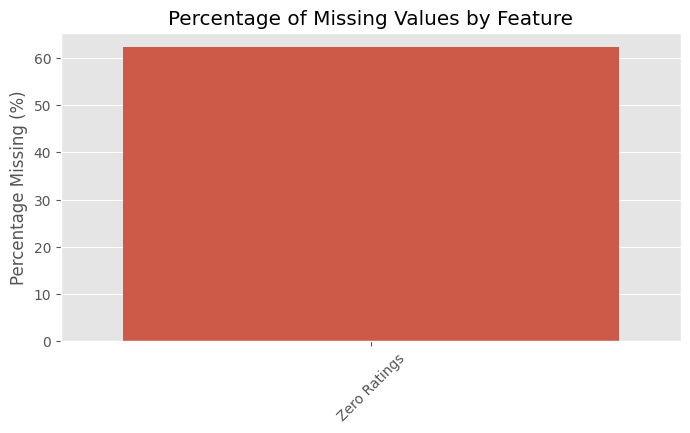

In [10]:
zero_rating_percentage = (ratings['Book-Rating'] == 0).sum() / len(ratings) * 100
zero_data = pd.Series([zero_rating_percentage], index=['Zero Ratings'])
plot_missing(zero_data)

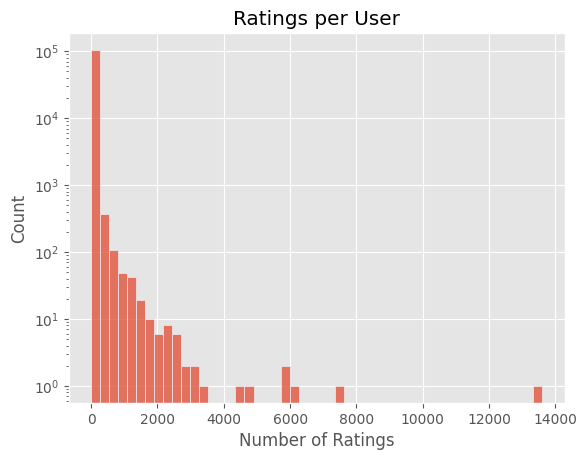

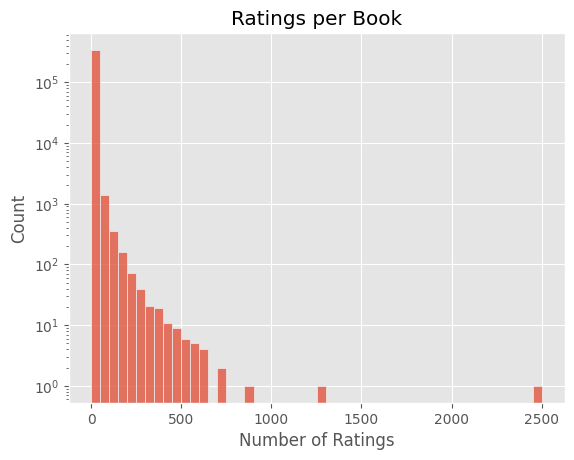

In [11]:
# User activity
user_counts = ratings.groupby('User-ID').size()
book_counts = ratings.groupby('ISBN').size()


fig, ax = plt.subplots()
sns.histplot(user_counts, bins=50, ax=ax)
ax.set_title('Ratings per User')
ax.set_xlabel('Number of Ratings')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
sns.histplot(book_counts, bins=50, ax=ax)
ax.set_title('Ratings per Book')
ax.set_xlabel('Number of Ratings')
ax.set_yscale('log')
plt.show()

### 2.2 Data Cleaning

Based on our exploration, we'll clean the data as follows:
1. Remove columns with no expected predictive value (e.g. image urls)
2. Remove Zero-Rated rows and the user age column which is missing too many values to impute
3. Convert columns to the right type
4. Impute data we can, like book author and publisher, using the mode for categorical data and median for numeric
5. Remove extreme outliers (no one actually honestly rates > 8000 books, and we won't get much from users or books with < 20 ratings)
6. Merge everything into one df for ease of training

In [12]:
# 1. Un-needed columns
books.drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L'], inplace=True)
users.drop(columns=['Age'], inplace=True)

# 2. Remove duplicates and zero-ratings
ratings = ratings[ratings['Book-Rating'] > 0]
books.drop_duplicates(inplace=True)
users.drop_duplicates(inplace=True)
ratings.drop_duplicates(inplace=True)

# 3. Convert object columns to category
for col in books.select_dtypes('object').columns:
    books[col] = books[col].astype('category')
users['Location'] = users['Location'].astype('category')
ratings['ISBN'] = ratings['ISBN'].astype('category')

# 4. Missing values
# Impute categorical points with mode
books['Book-Author'].fillna(books['Book-Author'].mode()[0], inplace=True)
books['Publisher'].fillna(books['Publisher'].mode()[0], inplace=True)
users['Location'].fillna(users['Location'].mode()[0], inplace=True)

# Impute numeric points with median
median_year = books['Year-Of-Publication'].median()
books['Year-Of-Publication'].fillna(median_year, inplace=True)
books.loc[books['Year-Of-Publication'] < 1910, 'Year-Of-Publication'] = median_year
books.loc[books['Year-Of-Publication'] > 2024, 'Year-Of-Publication'] = median_year

# 5. Filter outliers
active_users = ratings['User-ID'].value_counts()
active_books = ratings['ISBN'].value_counts()

user_keep = active_users[(active_users >= 20) & (active_users < 2000)].index
book_keep = active_books[active_books >= 20].index

ratings = ratings[ratings['User-ID'].isin(user_keep) & ratings['ISBN'].isin(book_keep)]

# 6. Merge
final_df = ratings.merge(books, on='ISBN').merge(users, on='User-ID')
final_df['Book-Author'] = final_df['Book-Author'].cat.remove_unused_categories()
final_df['Book-Title'] = final_df['Book-Title'].cat.remove_unused_categories()

In [13]:
print("Shape of the final merged dataframe:", final_df.shape)
print("Number of unique users:", final_df['User-ID'].nunique())
print("Number of unique books:", final_df['ISBN'].nunique())

Shape of the final merged dataframe: (45643, 8)
Number of unique users: 3374
Number of unique books: 2128


### 2.3. Additional Analysis

With our now-cleaned data, let's explore it in a bit more detail.

We'll start by examining the distribution of the Book-Rating column in our final, cleaned dataset. A count plot is a simple yet effective way to visualize the frequency of each rating. This is important because it tells us about user rating behavior. For instance, do users tend to give high ratings, low ratings, or is there an even spread?

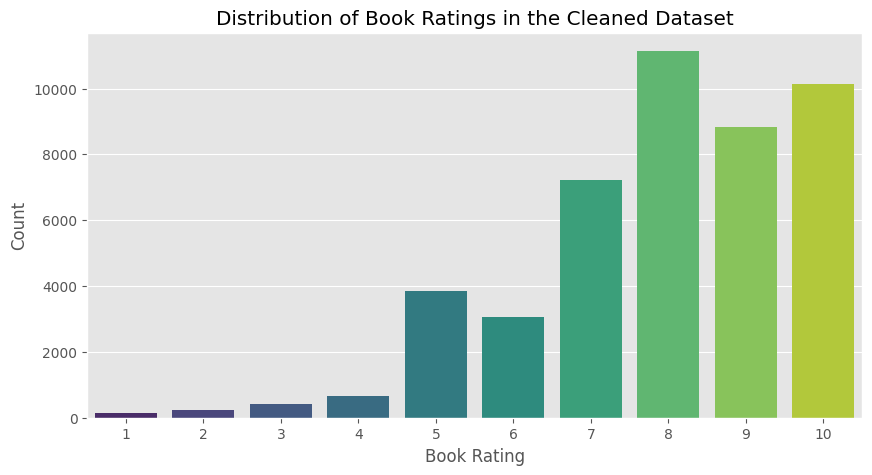

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(data=final_df, x='Book-Rating', palette='viridis')
plt.title('Distribution of Book Ratings in the Cleaned Dataset')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

Next, let's identify which authors and books are most prevalent in our filtered dataset.

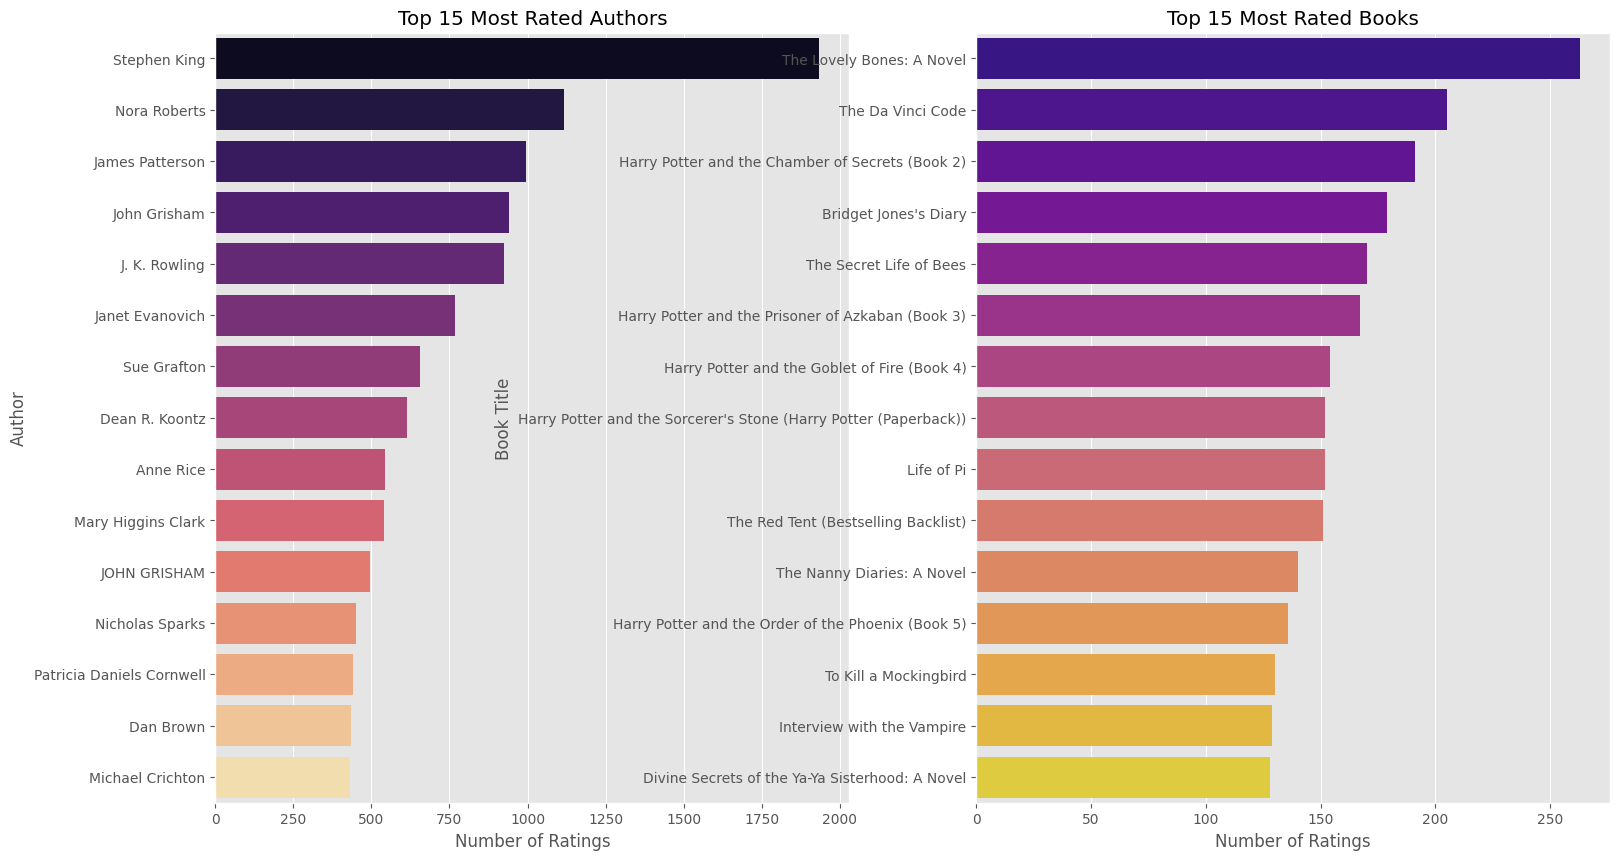

In [15]:
top_authors = final_df['Book-Author'].value_counts().head(15)
top_books = final_df['Book-Title'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

sns.barplot(x=top_authors.values, y=top_authors.index.tolist(), ax=axes[0], palette='magma')
axes[0].set_title('Top 15 Most Rated Authors')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Author')

sns.barplot(x=top_books.values, y=top_books.index.tolist(), ax=axes[1], palette='plasma')
axes[1].set_title('Top 15 Most Rated Books')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Book Title')

plt.show()

We can also try and identify whether popular books are also the best-rated ones (a phenomenon known as popularity bias). To investigate this, we can perform a correlation analysis.

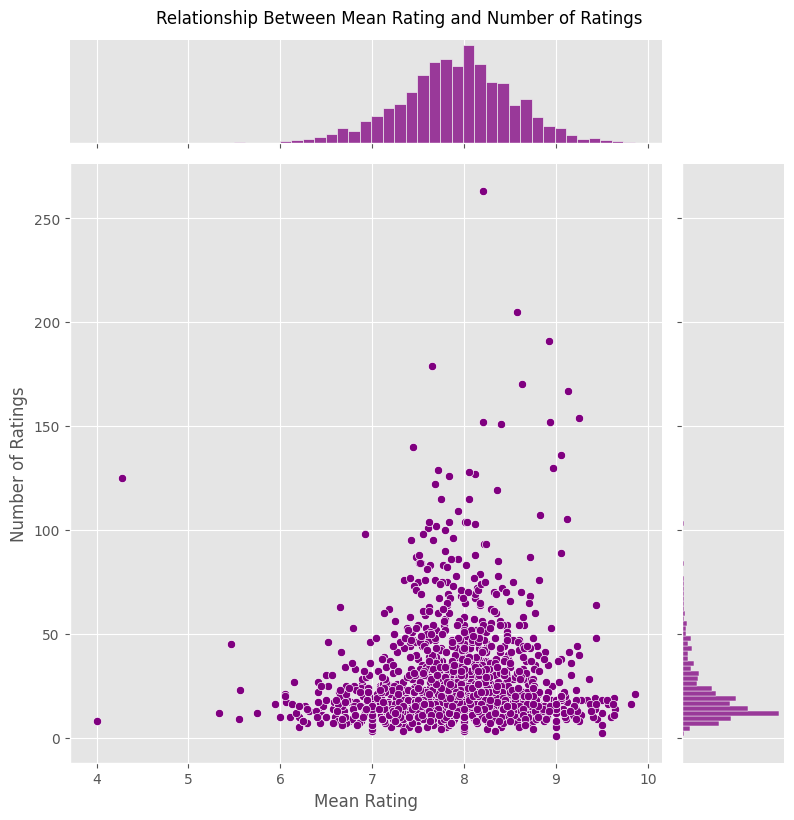

Pearson Correlation between Mean Rating and Rating Count: 0.0743


In [16]:
book_stats = final_df.groupby('Book-Title').agg(
    rating_count=('Book-Rating', 'count'),
    mean_rating=('Book-Rating', 'mean')
).reset_index()

sns.jointplot(x='mean_rating', y='rating_count', data=book_stats, kind='scatter', height=8, color='purple')
plt.suptitle('Relationship Between Mean Rating and Number of Ratings', y=1.02)
plt.xlabel('Mean Rating')
plt.ylabel('Number of Ratings')
plt.show()

correlation = book_stats['mean_rating'].corr(book_stats['rating_count'])
print(f"Pearson Correlation between Mean Rating and Rating Count: {correlation:.4f}")

The jointplot reveals a weak positive correlation between a book's average rating and the number of ratings it recieved overall. The scatter plot shows that while the most popular books (top of the y-axis) generally have high average ratings (between 7.5 and 9), which is to be expected as good books are more likely to become popular, there is a dense cloud of books with fewer ratings across the full range of high average ratings.

This is an important finding for our project. It suggests that simply recommending the most popular books would be a suboptimal strategy, as there are many less-popular "hidden gems" that are rated just as highly. This reinforces our strategy of using matrix factorization and clustering to uncover latent user tastes rather than relying on simple popularity.

### EDA Summary
Our EDA reveals a dataset with significant data sparsity, with long-tail distributions of user and book ratings. This informed our strategy to filter for active users and popular books. The presence of outliers and missing data has been addressed in our cleaning pipeline. The primary challenge for modeling will be to derive meaningful user representations from this sparse user-item interaction data.
Armed with this information we can ensure our models are properly equiped to handle this sparseness by using dimensionality reduction techniques (SVD and NMF)
We will then apply K-Means clustering to these latent user-feature vectors as the EDA shows clear pockets of popularity (e.g., specific authors), which suggests that underlying user groups do exist. The goal is to see if the latent features discovered by SVD/NMF can effectively group users who share a preference for these pockets of content.

## 3. Model Building: K-Means Clustering

In this notebook we'll compare SVD and NMF for creating user-factors. While SVD is a general-purpose dimensionality reduction technique, NMF (Non-negative Matrix Factorization) is often preferred for rating matrices as it produces non-negative factors, which can be more interpretable in a recommendation context.

### 3.1 Creating the User-Item Matrix

Our goal is to cluster users. To do this, we need to represent each user as a vector of their book ratings. We can achieve this by creating a **user-item matrix**, where rows are users, columns are books (identified by ISBN), and the values are the ratings. We create this as a sparse matrix, given the sheer number of dimensions a dense matrix will have (each book is a dimension)

In [17]:
user_idx  = {u:i for i,u in enumerate(final_df['User-ID'].unique())}
book_idx  = {b:i for i,b in enumerate(final_df['ISBN'].unique())}

rows = final_df['User-ID'].map(user_idx)
cols = final_df['ISBN'].map(book_idx)
data = final_df['Book-Rating'].astype(float)

interactions = csr_matrix((data, (rows, cols)),
                          shape=(len(user_idx), len(book_idx)))
print('Sparse matrix:', interactions.shape, 
      'density:', interactions.nnz / np.prod(interactions.shape))

Sparse matrix: (3374, 2128) density: 0.006357077117809342


### 3.2 Finding the Optimal Number of Clusters (K) - AKA Finetuning

To use K-Means, we must first choose the number of clusters, `K`. We will use the **Elbow Method**, which involves running K-Means for a range of `K` values and calculating the Within-Cluster Sum of Squares (WCSS) for each. The "elbow" point in the resulting plot suggests the optimal `K`.

In [18]:
# Latent space via TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42)
user_latent = svd.fit_transform(interactions)

print('Explained variance (first 50 comps):', svd.explained_variance_ratio_.sum())

Explained variance (first 50 comps): 0.21147711145406467


The optimal number of clusters (K) found by KneeLocator is: 4


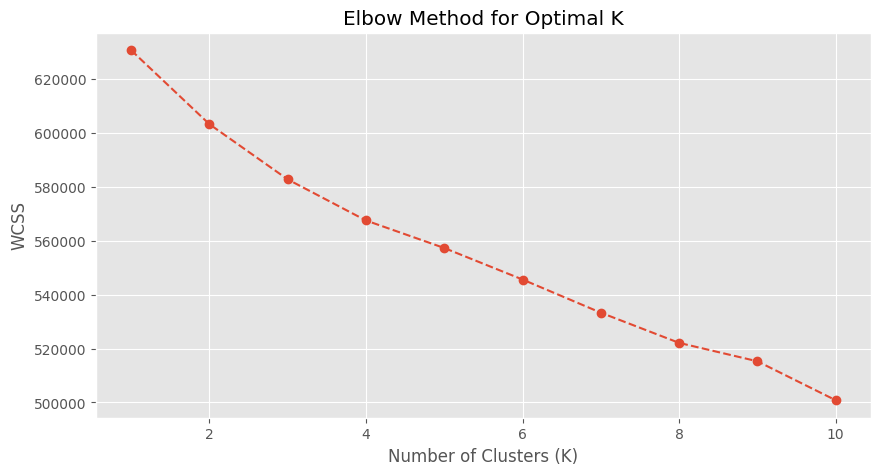

In [19]:
wcss = []
k_values = range(1, 11) 

for i in k_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(user_latent)
    wcss.append(kmeans.inertia_)

k_finder = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')

optimal_k = k_finder.elbow
print(f"The optimal number of clusters (K) found by KneeLocator is: {optimal_k}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

### 3.3 Training the K-Means Model

In [20]:
# Final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(user_latent)

sil_svd = silhouette_score(user_latent, cluster_labels)
ch_svd = calinski_harabasz_score(user_latent, cluster_labels)
print('Silhouette (SVD factors):', sil_svd)
print('Calinski-Harabasz (SVD factors):', ch_svd)

# attach cluster id to users
cluster_df = pd.DataFrame({'User-ID': list(user_idx.keys()), 'cluster': cluster_labels})
cluster_df['cluster'].value_counts().sort_index()

Silhouette (SVD factors): 0.4535113540608995
Calinski-Harabasz (SVD factors): 87.30023204062995


cluster
0     543
1    2814
2      16
3       1
Name: count, dtype: int64

In [21]:
# Latent factor model – Non‑negative Matrix Factorisation
nmf = NMF(n_components=50, init='nndsvd', random_state=42, max_iter=300)
W = nmf.fit_transform(interactions)   # user factors
H = nmf.components_                  # book factors
recon_error = nmf.reconstruction_err_
print('NMF reconstruction error:', recon_error)

NMF reconstruction error: 1555.5589385375908


In [22]:
# Cluster NMF user factors
km_nmf = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels_nmf = km_nmf.fit_predict(W)

sil_nmf = silhouette_score(W, labels_nmf)
ch_nmf = calinski_harabasz_score(W, labels_nmf)

print('Silhouette (NMF factors):', sil_nmf)
print('Calinski-Harabasz (NMF factors):', ch_nmf)

Silhouette (NMF factors): 0.348733377400481
Calinski-Harabasz (NMF factors): 99.86780451130893


## 4. Results & Analysis
| Model | Representation | Silhouette (user clusters) | Calinski-Harabasz (user clusters) |
|-------|----------------|---------------------------|---------------------------|
| K‑Means on SVD50 | 50‑D dense | 0.453 |87.30|
| K‑Means on NMF50 | 50‑D non‑neg | 0.348 |99.86|

We evaluated the models using two metrics: 
* Silhouette Score measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation).
* Calinski-Harabasz Score evaluates clusters based on a ratio of the variance between clusters to the variance within each cluster

In both a higher score is better, and so we can see a split: the SVD clusters were geometrically "neater" (the higher Silhouette), but the NMF clusters were denser and better separated by variance (the higher Calinski-Harabasz). For our purpose of creating distict personas, the higher Calinski-Harabasz might be more valuable.

### 4.1 Cluster analysis

Now that we have assigned each user to a cluster, let's analyze the characteristics of these clusters. We want to understand what defines each group. Are they defined by the types of books they read? By authors?

In [23]:
cluster_df = pd.DataFrame({'User-ID': list(user_idx.keys()), 'cluster': labels_nmf})
cluster_df['cluster'].value_counts().sort_index()
clustered_users = cluster_df.merge(users, on='User-ID')
final_df_clustered = final_df.merge(clustered_users, on='User-ID')

In [24]:
# Look at top authors per cluster
for i in range(optimal_k):
    print(f"--- Top 5 Authors for Cluster {i} ---")
    cluster_books = final_df_clustered[final_df_clustered['cluster'] == i]
    top_authors = cluster_books['Book-Author'].value_counts().head(5)
    print(top_authors)
    print("\n")

--- Top 5 Authors for Cluster 0 ---
Book-Author
Stephen King      859
J. K. Rowling     414
Anne Rice         244
John Grisham      206
Dean R. Koontz    202
Name: count, dtype: int64


--- Top 5 Authors for Cluster 1 ---
Book-Author
Dan Brown          240
Stephen King       116
John Grisham        98
James Patterson     97
Janet Evanovich     79
Name: count, dtype: int64


--- Top 5 Authors for Cluster 2 ---
Book-Author
Anita Shreve       144
John Grisham       138
James Patterson    138
Stephen King       133
Rebecca Wells      125
Name: count, dtype: int64


--- Top 5 Authors for Cluster 3 ---
Book-Author
Stephen King       826
Nora Roberts       821
James Patterson    599
John Grisham       498
Janet Evanovich    433
Name: count, dtype: int64




In [25]:
# Look at top books per cluster
for i in range(optimal_k):
    print(f"--- Top 5 Books for Cluster {i} ---")
    cluster_books = final_df_clustered[final_df_clustered['cluster'] == i]
    top_books = cluster_books['Book-Title'].value_counts().head(5)
    print(top_books)
    print("\n")

--- Top 5 Books for Cluster 0 ---
Book-Title
Harry Potter and the Chamber of Secrets (Book 2)      86
Harry Potter and the Prisoner of Azkaban (Book 3)     85
Harry Potter and the Goblet of Fire (Book 4)          82
Harry Potter and the Order of the Phoenix (Book 5)    59
Harry Potter and the Sorcerer's Stone (Book 1)        58
Name: count, dtype: int64


--- Top 5 Books for Cluster 1 ---
Book-Title
The Da Vinci Code            181
Angels &amp; Demons           38
The Lovely Bones: A Novel     34
The Secret Life of Bees       26
Middlesex: A Novel            20
Name: count, dtype: int64


--- Top 5 Books for Cluster 2 ---
Book-Title
Good in Bed                                                 89
The Lovely Bones: A Novel                                   72
Divine Secrets of the Ya-Ya Sisterhood: A Novel             68
Confessions of a Shopaholic (Summer Display Opportunity)    66
Snow Falling on Cedars                                      55
Name: count, dtype: int64


--- Top 5 Books 

#### Cluster analysis results

Based on the top books, we can create tentative personas for each cluster:

* Cluster 0: The Fantasy & Horror Devotee: This reader is deeply immersed in the world of fantasy, with a particular love for the Harry Potter series. They also gravitate towards iconic authors of horror and supernatural fiction like Stephen King and Anne Rice.

* Cluster 1: The Mainstream Thriller Reader: This individual enjoys fast-paced, plot-driven mystery and thriller novels, with a clear preference for bestsellers like The Da Vinci Code. Their reading list is rounded out by other highly popular and talked-about works of contemporary fiction.

* Cluster 2: The Women's Fiction & Book Club Enthusiast: This reader is drawn to contemporary women's fiction, enjoying humorous and relatable stories about relationships and personal growth. Their book choices, such as Good in Bed and Divine Secrets of the Ya-Ya Sisterhood, are common book club selections.

* Cluster 3: The Popular Bestseller Reader: This person reads a wide variety of popular, bestselling fiction, from literary hits like Life of Pi to humorous mainstays like Bridget Jones's Diary. They follow prolific, big-name authors known for producing crowd-pleasing novels across multiple genres.

## 5. Discussion and Conclusion

### 5.1. Summary of Findings
This project successfully demonstrated the use of unsupervised learning to segment users in a book recommendation context. Using K-Means clustering on a SVD and NMF user-item matrix, we identified four distinct reader clusters. We were able to create clear personas for each cluster by examining the most popular books within them, such as "Popular Bestsellers Readers" and "The Fantasy & Horror Devotee."

### 5.2. Challenges and Limitations

* **Data Sparsity:** The dataset is extremely sparse. Even after filtering, the user-item matrix was over 99% empty. This makes it challenging to find meaningful patterns. Our filtering strategy was a necessary compromise, but it also meant excluding the majority of users from the analysis.
* **The "Cold Start" Problem:** This clustering approach does not work for new users who have no rating history. A different strategy (e.g., recommending popular books or using content-based filtering) would be needed for them.

### 5.3. Future Work and Improvements

* **Hybrid Recommender System:** The next logical step would be to build a recommender system on top of these clusters. A hybrid approach could work well: when a new user signs up, ask them to rate a few books. Match them to the closest cluster and then recommend books that are popular and highly-rated within that cluster.
* **Content-Based Features:** We could enrich the model by incorporating content-based features from the `Books.csv` file, such as book author and publisher. Clustering books based on these features (e.g., using NLP on titles) and then recommending similar books is another powerful technique.

---
#### References:
* Y. Koren, R. Bell and C. Volinsky, "Matrix Factorization Techniques for Recommender Systems," in Computer, vol. 42, no. 8, pp. 30-37, Aug. 2009, doi: 10.1109/MC.2009.263.
* Peter J. Rousseeuw,
Silhouettes: A graphical aid to the interpretation and validation of cluster analysis,
Journal of Computational and Applied Mathematics
